In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from array import array
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_pi = 0.13957
m_K = 0.49368
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

mD* - mD0 = 0.14543


In [4]:
label_dic = {'Data' : 'Data',
             'mu'   : 'B#rightarrow D*#mu#nu',
             'tau'  : 'B#rightarrow D*#tau#nu',
             'Hc'   : 'B#rightarrow D*H_{c}',
             'Dstst': 'B#rightarrow D**#mu#nu'
            }

In [5]:
colors = {'data':rt.kBlack,
          'mu': rt.kAzure+1, 
          'tau': rt.kRed-4, 
          'Hc':rt.kGreen+1, 
          'Dstst': rt.kViolet-7,
          'combDstMum' : rt.kGray+1
         }

In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [8]:
# loc = '../data/cmsRD/'
# loc += 'ParkingBPH1/'
# loc += 'Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_191126_CAND.root'

# tData = rt.TChain('outA/Tevts')
# for floc in glob(loc):
#     tData.Add(floc)

# print 'N evts: {:.0f}'.format(tData.GetEntries())

In [9]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tMu = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tMu.Add(floc)

print 'N evts: {:.0f}'.format(tMu.GetEntries())

N evts: 1484198


In [10]:
# loc = '../data/cmsMC_private/'
# loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU0_10-2-3'
# loc += '/ntuples_B2DstMu/out_CAND_*.root'

# tMu0 = rt.TChain('outA/Tevts')
# for floc in glob(loc):
#     tMu0.Add(floc)

# print 'N evts: {:.0f}'.format(tMu.GetEntries())

In [11]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tTau = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tTau.Add(floc)

print 'N evts: {:.0f}'.format(tTau.GetEntries())

N evts: 167393


In [12]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tDstst = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tDstst.Add(floc)

print 'N evts: {:.0f}'.format(tDstst.GetEntries())

N evts: 199562


In [13]:
# loc = '../data/cmsMC_private/'
# loc += 'BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU0_10-2-3'
# loc += '/ntuples_B2DstMu/out_CAND_*.root'

# tDstst0 = rt.TChain('outA/Tevts')
# for floc in glob(loc):
#     tDstst0.Add(floc)

# print 'N evts: {:.0f}'.format(tDstst0.GetEntries())

In [14]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tHc = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tHc.Add(floc)

print 'N evts: {:.0f}'.format(tHc.GetEntries())

N evts: 86228


In [15]:
def addOverflow(hh):
    Nbins = hh.GetNbinsX()
    hh.SetBinContent(Nbins, hh.GetBinContent(Nbins) + hh.GetBinContent(Nbins+1))
    hh.SetBinContent(Nbins+1, 0)
    return

# Cuts declaration

In [16]:
cut_general = [
    'n_B == 1',
    'trgMu_pt > 12.1',
    'trgMu_sigdxy > 7',
    'abs(trgMu_eta) < 1.5',
]

$D_0$ reconstruction

In [17]:
cut_piK = [
####----- Trigger-like cuts -----#
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
'abs(mass_piK - 1.864) < 0.05',
'sigdxy_vtxD0_PV > 2'
]

# $D^*$ Recostruction

In [18]:
cut_D0pis = [
'pis_pt > 0.4',
'abs(pis_eta) < 2.4',
'sigdxy_pis_PV > 2',
'pval_D0pis > 0.1',
'abs(mass_D0pis - 2.01) < 0.03',
'1e3*abs(mass_D0pis - mass_piK - 0.14543) < 2.',
]

# Full analysis

In [19]:
cut_B = [
'pval_D0pismu > 0.1',
'cos_D0pismu_PV > 0.99',
'mass_D0pismu < 7.0',
]

cut_str = ' && '.join(cut_general + cut_piK + cut_D0pis + cut_B)

# Study on the additional tracks

In [20]:
def drawPlot(var, addCut, binning, axis_title, logy=True, logx=False, addSel=''):
    h = create_TH1D(np.zeros(0), name='h',
                    title='', axis_title=axis_title,
                    binning=binning )
    tMu.Project('h', var, cut_str + addSel)
    h.Sumw2()
    addOverflow(h)
    h.Scale(1./h.Integral())
    h.SetLineColor(colors['mu'])
    h.SetLineWidth(3)
    N = tMu.GetEntries(cut_str + addSel)
    n = tMu.GetEntries(cut_str + addSel + addCut)
    print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
    tTau.Project('h3', var, cut_str + addSel)
    h3.Sumw2()
    addOverflow(h3)
    h3.Scale(1./h3.Integral())
    h3.SetLineColor(colors['tau'])
    h3.SetLineWidth(3)
    N = tTau.GetEntries(cut_str + addSel)
    n = tTau.GetEntries(cut_str + addSel + addCut)
    print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
    tDstst.Project('h2', var, cut_str + addSel)
    h2.Sumw2()
    addOverflow(h2)
    h2.Scale(1./h2.Integral())
    h2.SetLineColor(colors['Dstst'])
    h2.SetLineWidth(3)
    N = tDstst.GetEntries(cut_str + addSel)
    n = tDstst.GetEntries(cut_str + addSel + addCut)
    print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    h1 = create_TH1D(np.zeros(0), name='h1', binning=h.binning)
    tHc.Project('h1', var, cut_str + addSel)
    h1.Sumw2()
    addOverflow(h1)
    h1.Scale(1./h1.Integral())
    h1.SetLineColor(colors['Hc'])
    h1.SetLineWidth(3)
    N = tHc.GetEntries(cut_str + addSel)
    n = tHc.GetEntries(cut_str + addSel + addCut)
    print 'Hc: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

    leg = rt.TLegend(0.6, 0.55, 0.9, 0.94)
    leg.AddEntry(h, label_dic['mu'], 'l')
    leg.AddEntry(h3, label_dic['tau'], 'l')
    leg.AddEntry(h2, label_dic['Dstst'], 'l')
    leg.AddEntry(h1, label_dic['Hc'], 'l')
    leg.SetTextFont(42)
    leg.SetTextAlign(12)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    m = SetMaxToMaxHist([h, h1, h2, h3])
    c = drawOnCMSCanvas(CMS_lumi, [h, h1, h2, h3], 'same')
    if logy: 
        c.SetLogy()
    if logx: 
        c.SetLogx()
    leg.Draw()
    c.Draw()
    c.leg=leg
    return c, m

Mu: 254265/301918 = 84.2 %
Tau: 20905/23932 = 87.4 %
Dstst: 6213/34665 = 17.9 %
Hc: 6419/9654 = 66.5 %


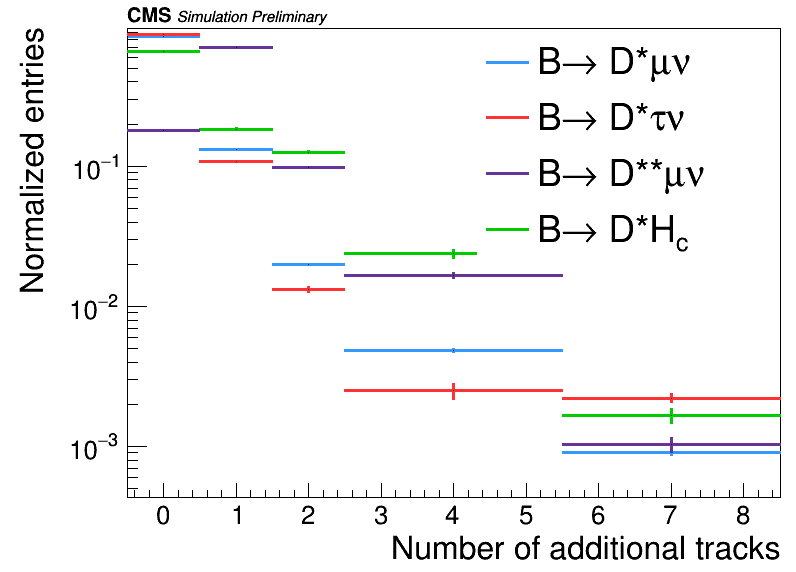

In [21]:
c = drawPlot('nTksAdd', ' && nTksAdd == 0', 
         array('d', list(np.arange(-0.5, 3.5, 1)) + [5.5, 8.5] ), 
         ['Number of additional tracks', 'Normalized entries'], 
         logy=True)

Mu: 4832/301918 = 1.6 %
Tau: 246/23932 = 1.0 %
Dstst: 19919/34665 = 57.5 %
Hc: 813/9654 = 8.4 %


<ROOT.TLine object ("TLine") at 0xaec9c60>

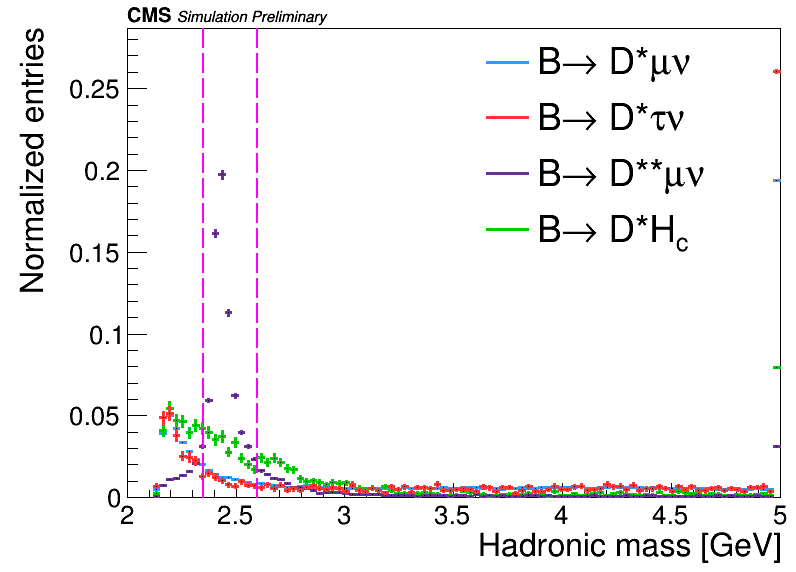

In [22]:
c, m = drawPlot('tksAdd_massHad', ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6', 
         [100, 2, 5], 
         ['Hadronic mass [GeV]', 'Normalized entries'], 
         logy=False)

cl.DrawLine(2.35, 0, 2.35, m)
cl.DrawLine(2.6, 0, 2.6, m)

Mu: 19195/301918 = 6.4 %
Tau: 1368/23932 = 5.7 %
Dstst: 26015/34665 = 75.0 %
Hc: 2603/9654 = 27.0 %


<ROOT.TLine object ("TLine") at 0xaf1cee0>

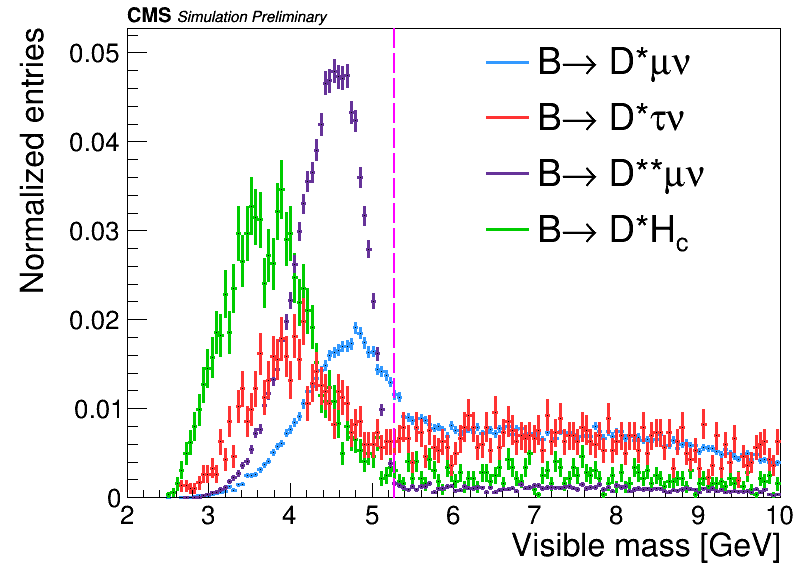

In [23]:
c, m = drawPlot('tksAdd_massVis', ' && tksAdd_massVis < {}'.format(m_B0), 
         [150, 2, 10], 
         ['Visible mass [GeV]', 'Normalized entries'], 
         logy=False)

cl.DrawLine(m_B0, 0, m_B0, m)

Mu: 17558/301918 = 5.8 %
Tau: 1093/23932 = 4.6 %
Dstst: 24137/34665 = 69.6 %
Hc: 2497/9654 = 25.9 %


<ROOT.TLine object ("TLine") at 0xb3822f0>

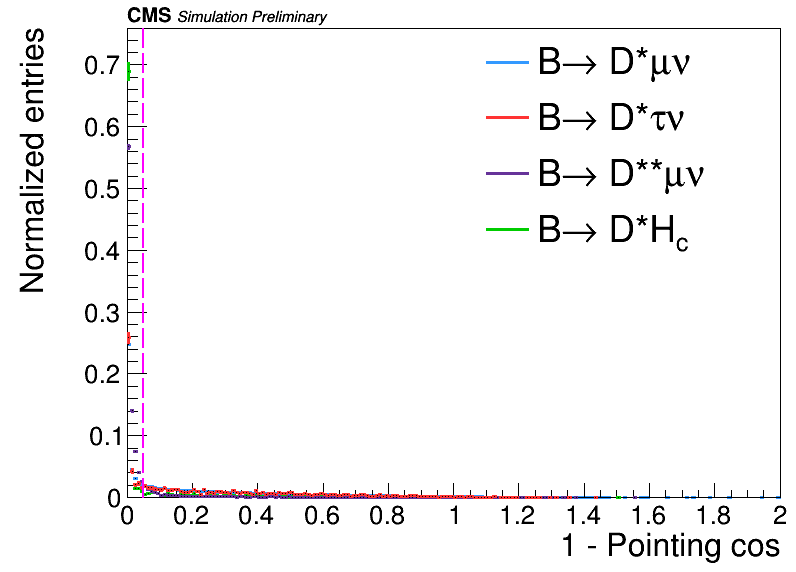

In [24]:
c, m = drawPlot('1-tksAdd_cos_PV', ' && tksAdd_cos_PV > 0.95', 
         [200, 0, 2], 
         ['1 - Pointing cos', 'Normalized entries'], 
         logy=False,
         logx=False,
        )

cl.DrawLine(0.05, 0, 0.05, m)

Mu: 18593/301918 = 6.2 %
Tau: 1171/23932 = 4.9 %
Dstst: 22510/34665 = 64.9 %
Hc: 2531/9654 = 26.2 %


<ROOT.TLine object ("TLine") at 0x9e89320>

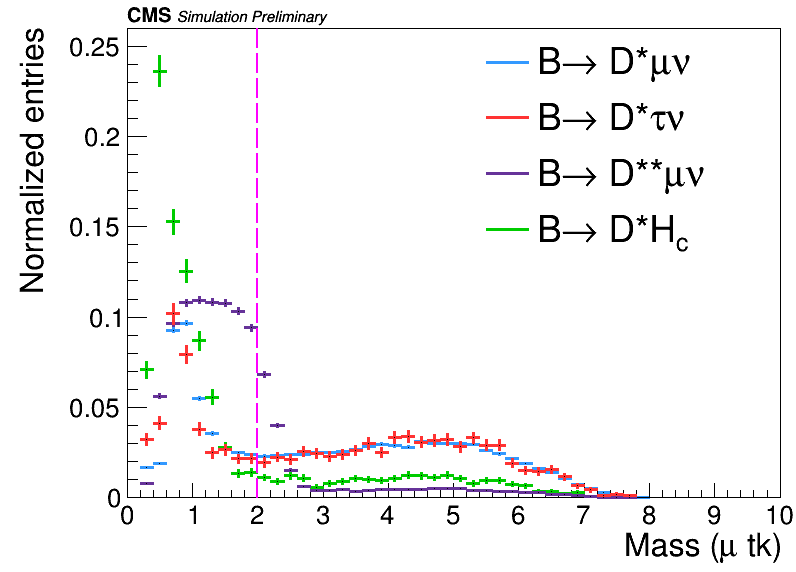

In [25]:
c, m = drawPlot('tksAdd_massMuTk', ' && tksAdd_massMuTk < 2', 
         [50, 0,10], 
         ['Mass (#mu tk)', 'Normalized entries'], 
         logy=False)

cl.DrawLine(2, 0, 2, m)

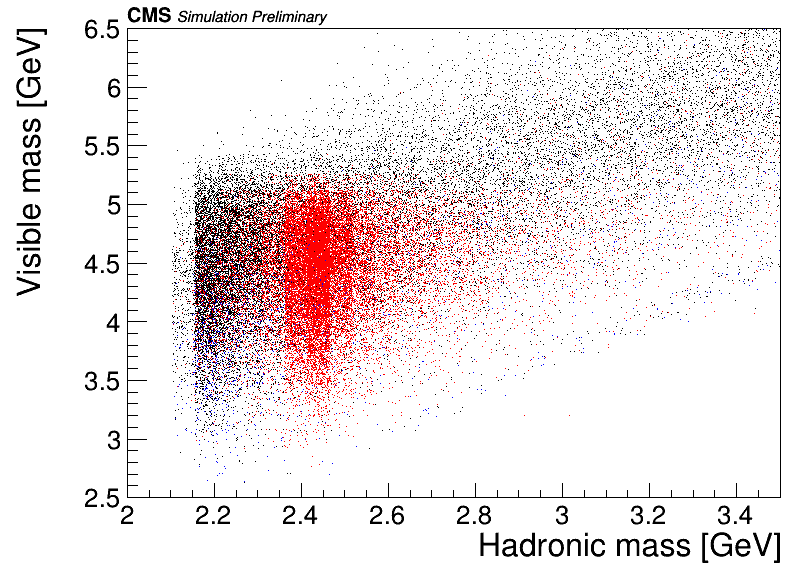

In [26]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['Hadronic mass [GeV]', 'Visible mass [GeV]', 'Events'],
                binning=[np.linspace(2, 3.5, 30), np.linspace(2.5, 6.5, 30)]
               )
tMu.Project('h', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h.Sumw2()

h2 = create_TH2D(np.zeros((2,2)), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h2.Sumw2()
h2.SetMarkerColor(rt.kRed)

h3 = create_TH2D(np.zeros((2,2)), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h3.Sumw2()
h3.SetMarkerColor(rt.kBlue)
                         
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
# cl.DrawLine(1.76, 1.76+0.16, 1.91, 1.91+0.16)
# c.SetLogy()
c.Draw()

Mu: 283723/301918 = 94.0 %
Tau: 22711/23932 = 94.9 %
Dstst: 8469/34665 = 24.4 %
Hc: 6990/9654 = 72.4 %


<ROOT.TLine object ("TLine") at 0xad7bab0>

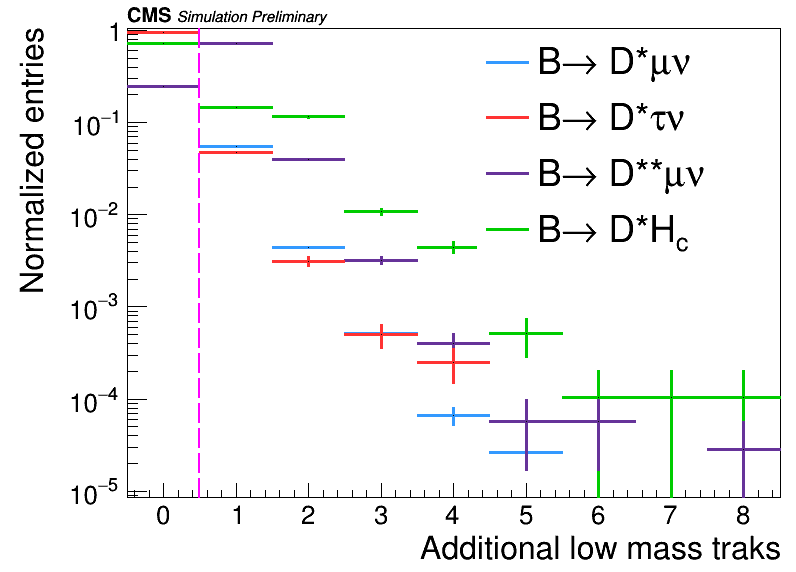

In [27]:
c, m = drawPlot('Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95)'.format(m_B0), 
                ' && Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) < 1'.format(m_B0), 
                [9, -0.5,8.5], 
                ['Additional low mass traks', 'Normalized entries']
               )

cl.DrawLine(0.5, 0, 0.5, m)

Mu: 3442/18195 = 18.9 %
Tau: 197/1221 = 16.1 %
Dstst: 18723/26196 = 71.5 %
Hc: 797/2664 = 29.9 %


<ROOT.TLine object ("TLine") at 0xb380870>

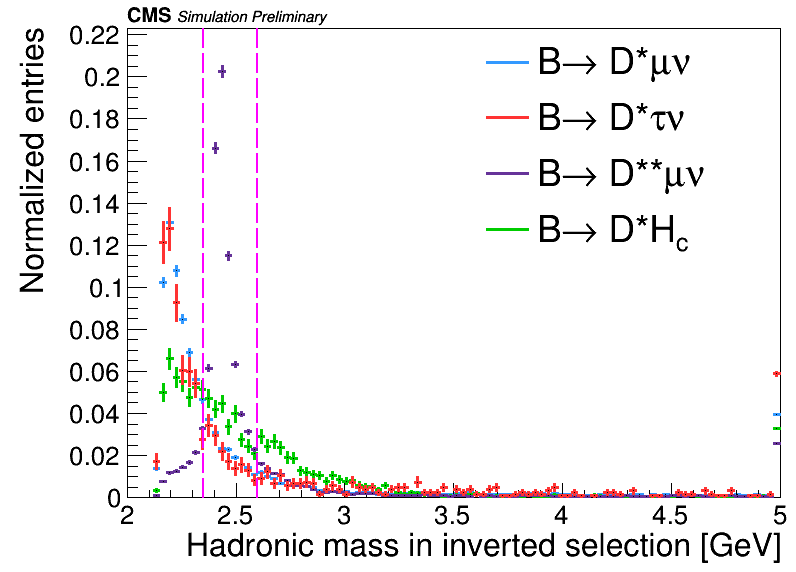

In [28]:
c, m = drawPlot('tksAdd_massHad', ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6',
                addSel = ' && Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) > 0'.format(m_B0), 
                binning=[100, 2, 5], 
                axis_title=['Hadronic mass in inverted selection [GeV]', 'Normalized entries'],
                logy=False)

cl.DrawLine(2.35, 0, 2.35, m)
cl.DrawLine(2.6, 0, 2.6, m)

Mu: 15674/18195 = 86.1 %
Tau: 1040/1221 = 85.2 %
Dstst: 21531/26196 = 82.2 %
Hc: 2466/2664 = 92.6 %


<ROOT.TLine object ("TLine") at 0x9c34da0>

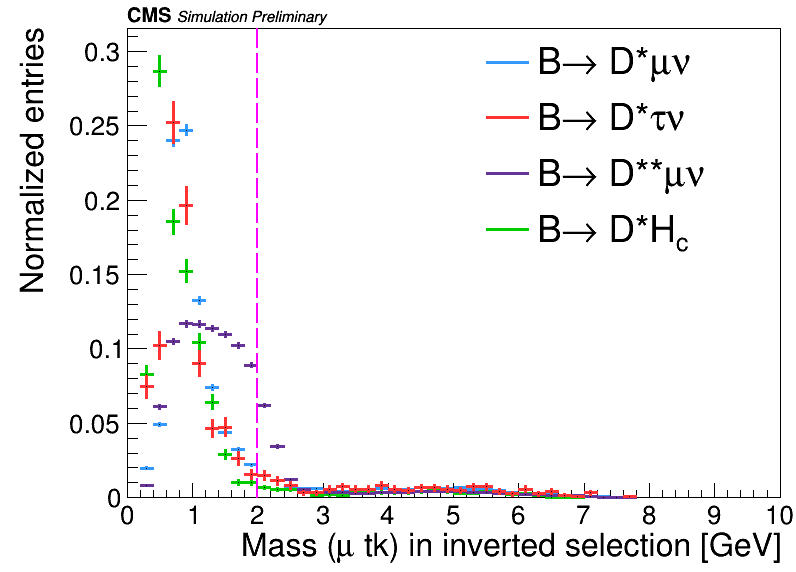

In [29]:
c, m = drawPlot('tksAdd_massMuTk', ' && tksAdd_massMuTk < 2',
                addSel = ' && Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) > 0'.format(m_B0), 
                binning=[50, 0,10], 
                axis_title=['Mass (#mu tk) in inverted selection [GeV]', 'Normalized entries'],
                logy=False)

cl.DrawLine(2, 0, 2, m)

Mu: 4256/301918 = 1.4 %
Tau: 265/23932 = 1.1 %
Dstst: 20940/34665 = 60.4 %


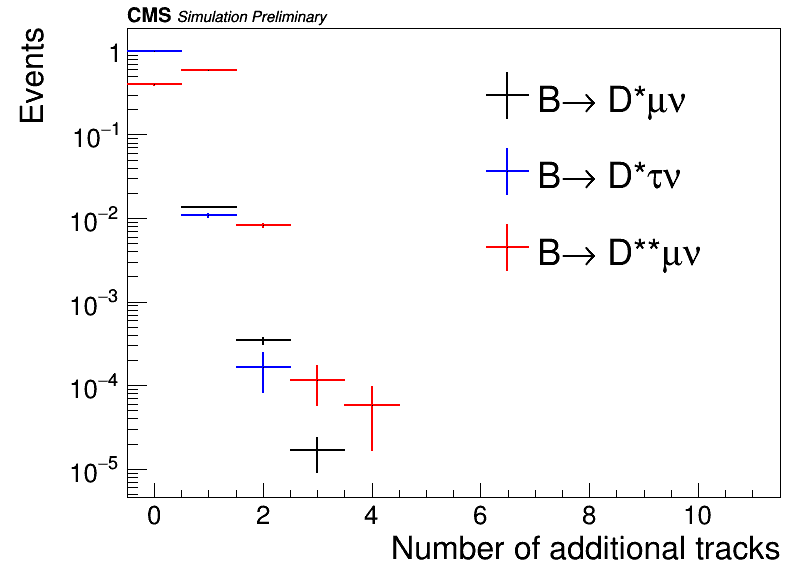

In [30]:
# var = 'Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95)'.format(m_B0)
var = 'Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95 && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6)'.format(m_B0)

h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Number of additional tracks', 'Events'],
                binning=[12, -0.5, 11.5]
               )
tMu.Project('h', var, cut_str)
h.Sumw2()
h.Scale(1./h.Integral())
N = tMu.GetEntries(cut_str)
n = tMu.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', var, cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', var, cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)


# h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
# tData.Project('h4', var, cut_str)
# h4.Sumw2()
# h4.Scale(1./h4.Integral())
# h4.SetLineColor(rt.kAzure)
# N = tData.GetEntries(cut_str)
# n = tData.GetEntries(cut_str + ' && {} >= 1'.format(var))
# print 'Data: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.5, 0.9, 0.9)
leg.AddEntry(h, label_dic['mu'], 'lep')
leg.AddEntry(h3, label_dic['tau'], 'lep')
leg.AddEntry(h2, label_dic['Dstst'], 'lep')
# leg.AddEntry(h4, label_dic['Data'], 'lep')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
leg.Draw()
c.Draw()

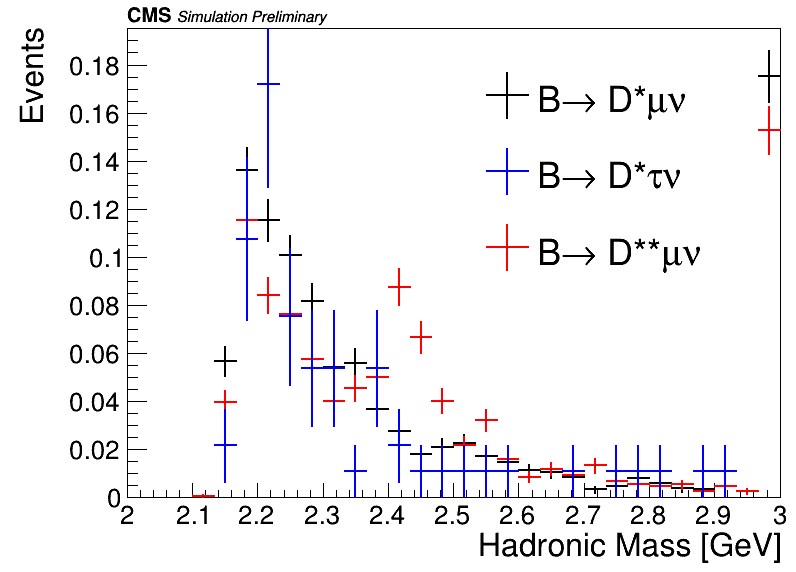

In [31]:
sel = 'Sum$(tksAdd_massVis < {} && tksAdd_cos_PV > 0.95) > 1'.format(m_B0)
# var = 'tksAdd_pval'
var= 'tksAdd_massHad'
# var= 'tksAdd_pt'

h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Hadronic Mass [GeV]', 'Events'],
                binning=[30, 2., 3.]
#                 axis_title=['pval', 'Events'],
#                 binning=[50, 0, 1.]
#                 axis_title=['pT [GeV]', 'Events'],
#                 binning=[50, 0, 5.]
               )
tMu.Project('h', var, cut_str + ' && ' + sel)
addOverflow(h)
h.Sumw2()
h.Scale(1./h.Integral())

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', var, cut_str + ' && ' + sel)
addOverflow(h3)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', var, cut_str + ' && ' + sel)
addOverflow(h2)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)


# h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
# tData.Project('h4', var, cut_str)
# h4.Sumw2()
# h4.Scale(1./h4.Integral())
# h4.SetLineColor(rt.kAzure)
# N = tData.GetEntries(cut_str)
# n = tData.GetEntries(cut_str + ' && {} >= 1'.format(var))
# print 'Data: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.5, 0.9, 0.9)
leg.AddEntry(h, label_dic['mu'], 'lep')
leg.AddEntry(h3, label_dic['tau'], 'lep')
leg.AddEntry(h2, label_dic['Dstst'], 'lep')
# leg.AddEntry(h4, label_dic['Data'], 'lep')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
leg.Draw()
c.Draw()